In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import pyzx
from typing import List,Tuple
from pyzx.graph.base import BaseGraph, VT, ET

In [239]:
class SimulatedAnnealer:
    """
    Attributes:
        initial_temp (float): 初期温度
        final_temp (float): 最終温度
        cooling_rate (float): 冷却率 (0 < alpha < 1)
        max_iterations (int): 各温度での最大試行回数
    """

    def __init__(self, initial_temp, final_temp, cooling_rate, max_iterations):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations

    def _acceptance_probability(self, o, new_score, temp):
        """
        悪い解への遷移を受理する確率を計算する。
        exp(-delta_E / T)
        """
        if new_score < old_score:
            return 1.0
        # new_score >= old_score の場合（スコアが悪化した場合）
        delta_score = new_score - old_score
        return math.exp(-delta_score / temp)

    def solve(self, initial_state: BaseGraph, evaluate_func, get_neighbor_func):
        """
        焼きなまし法を実行して最適解を探す。

        Args:
            initial_state: 初期状態
            evaluate_func: 状態を評価する関数
            get_neighbor_func: 近傍の状態を生成する関数

        Returns:
            (best_state, best_score): 見つかった最も良い状態とその評価値
        """
        current_temp = self.initial_temp
        current_state = initial_state
        current_score = evaluate_func(current_state)

        best_state = current_state
        best_score = current_score

        history = {'temp': [], 'score': []}
        print(f"初期スコア: {best_score}")
        iteration_count = 0

        while current_temp > self.final_temp:

            # 1. 近傍の状態を生成
            neighbor = get_neighbor_func(current_state)


            #yamanobori

            """
            # 3. 遷移を許容するか決定
            prob = self._acceptance_probability(current_score, neighbor_score, current_temp)
            if random.random() < prob:
                current_state = neighbor_state
                current_score = neighbor_score
            """
            if (not neighbor):
                return best_state, best_score, history


            current_state = neighbor[0][0]
            current_score = neighbor[0][1]

            # 4. 最良解を更新
            if current_score < best_score:
                best_state = current_state
                best_score = current_score
            
            # 履歴を保存
            history['temp'].append(current_temp)
            history['score'].append(current_score)
            print(f"温度: {current_temp:.2f}, 現在スコア: {current_score}, 最良スコア: {best_score}")

            # 5. 温度を更新（冷却）
            current_temp *= self.cooling_rate

        return best_state, best_score, history
    
    """
    #状態のスコアを計算
    def score():

    def get_neighbor_func():
    

    #グラフに対して、簡約化操作とそのノード一覧
    def get_action():
    
        Args:
        initial_state: 初期状態
        evaluate_func: 状態を評価する関数
        get_neighbor_func: 近傍の状態を生成する関数

    Returns:
        (best_state, best_score): 見つかった最も良い状態とその評価値

"""


In [232]:
def generate_H_S_CNOT_T_circuit(qubits, gates, p_t=0, seed=1000):
    random.seed(seed)  
    p_s = 0.333 * (1.0 - p_t)  
    p_had = 0.333 * (1.0 - p_t)  
    p_cnot = 0.333 * (1.0 - p_t)  

    c = pyzx.Circuit(qubits) 
    for _ in range(gates):
        r = random.random() 
        if r < p_had:
            c.add_gate("HAD", random.randrange(qubits))
        elif r < p_had + p_s:
            c.add_gate("S", random.randrange(qubits))
        elif r < p_had + p_s + p_t:
            c.add_gate("T", random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl != tgt:
                    break
            c.add_gate("CNOT", tgt, ctrl)
    return c

In [ ]:

"""
def apply_lcomp(g:BaseGraph ,match: Tuple[int,List[int]]):
    print(match)
    etab, rem_verts, rem_edges, check_isolated_vertices = pyzx.rules.lcomp(g,[match])
    g.add_edge_table(etab)
    g.remove_edges(rem_edges)
    g.remove_vertices(rem_verts)
    if check_isolated_vertices: g.remove_isolated_vertices()
    return g

def apply_pivot(g:BaseGraph, match: Tuple[int,int ,List[int],List[int]]):
    print(match)
    etab, rem_verts, rem_edges, check_isolated_vertices = pyzx.rules.pivot(g, [match])
    g.add_edge_table(etab)
    g.remove_edges(rem_edges)
    g.remove_vertices(rem_verts)
    if check_isolated_vertices: g.remove_isolated_vertices()
    return g
"""

def get_actions(g:BaseGraph):
    lc = pyzx.rules.match_lcomp_parallel(g)
    pv = pyzx.rules.match_pivot_parallel(g)
    return lc,pv

def print_graph_data(g: BaseGraph):
    boundarycount= 0
    for v in g.vertices():

        if (g.type(v) == 0):
            vtype = "Boundary"
            boundarycount +=1
        else:
            vtype = "Z"

        phase = g.phase(v)
        neighbors = g.neighbors(v)
        print(f"Vertex {v}:")
        print(f"  Type: {vtype}")
        print(f"  Phase: {phase}")
        print(f"  Neighbors: {neighbors}")
    
    for e in g.edges():
        s, t = g.edge_st(e)
        etype = g.edge_type(e)
        print(f"Edge {e}: {s} --({etype})-- {t}")
    print("boudarycount",boundarycount)

def get_gate_num(g:BaseGraph):
    g_tmp = g.copy()
    c = pyzx.extract.extract_circuit(g_tmp,up_to_perm=True)
    c = pyzx.optimize.basic_optimization(c)
    a = c.stats_dict()
    dict = {}
    dict["all"] = a["gates"]
    dict["two"] = a["twoqubit"]
    dict["one"] = a["gates"] - a["twoqubit"]
    dict["t"] = a["tcount"]
    return dict

def get_node_and_edge_num(g:BaseGraph) -> Tuple[int, int]:
    a= g.num_vertices()
    b = g.num_edges()
    return a,b

def score(g:BaseGraph) -> int:
    a = get_gate_num(g)
    score = 10 * a["two"] + a["one"]
    return score

def get_neighbor_scores(g: BaseGraph) -> List[Tuple[BaseGraph, int]]:
    """
    現在のグラフ状態から遷移可能な全ての近傍状態を生成し、
    それぞれの状態とそのスコアのペアをリストとして返す。

    Args:
        g (BaseGraph): 現在のグラフ状態。

    Returns:
        List[Tuple[BaseGraph, int]]: (近傍のグラフ状態, そのスコア) のタプルで構成されるリスト。
    """
    # 適用可能な操作（lcompとpivot）のリストを取得

    #g.copyは、元の頂点番号を変化させる場合があるので、get_actionsとapply_rule対象のグラフは同じでなければならない
    g2 = g.copy()
    lcomp_matches, pivot_matches = get_actions(g2)
    
    neighbor_list = []

    # lcomp操作を適用した近傍を生成・評価
    for match in lcomp_matches:
        g_tmp = g2.copy()
        pyzx.rules.apply_rule(g_tmp, pyzx.rules.lcomp, [match], check_isolated_vertices=True)
        pyzx.simplify.id_simp(g_tmp,quiet=True)
        pyzx.simplify.spider_simp(g_tmp,quiet=True)
        neighbor_list.append((g_tmp, score(g_tmp)))


    # pivot操作を適用した近傍を生成・評価
    for match in pivot_matches:
        g_tmp = g.copy()
        pyzx.rules.apply_rule(g_tmp, pyzx.rules.pivot, [match], check_isolated_vertices=True)
        pyzx.simplify.id_simp(g_tmp,quiet=True)
        pyzx.simplify.spider_simp(g_tmp,quiet=True)
        neighbor_list.append((g_tmp, score(g_tmp)))

    return neighbor_list

In [228]:
#実験用のコード
# 1. 初期グラフの準備
c = generate_H_S_CNOT_T_circuit(8, 200, p_t=0.08, seed=1000)
g = c.to_graph()
pyzx.simplify.spider_simp(g)
pyzx.simplify.to_gh(g) #red node -> green
pyzx.simplify.id_simp(g)
pyzx.draw(g)

# 2. 現在の状態のスコアを表示
current_score = score(g)
print(f"現在のスコア: {current_score}\n")

# 3. 近傍のスコア一覧を取得して表示
neighbor_scores_list = get_neighbor_scores(g)
print("--- 遷移可能な近傍のスコア一覧 ---")
if not neighbor_scores_list:
    print("遷移可能な近傍はありません。")
else:
    for i, (neighbor_state, neighbor_score) in enumerate(neighbor_scores_list):
        print(f"近傍 {i+1}: スコア = {neighbor_score}")

print(f"\n合計 {len(neighbor_scores_list)} 個の近傍が見つかりました。")

# スコア順に昇順でソート
neighbor_scores_list = sorted(neighbor_scores_list, key=lambda x: x[1])

print(neighbor_scores_list)


spider_simp: 51. 32. 19. 10. 6. 2. 1.  7 iterations
id_simp: 28. 5. 1.  3 iterations


現在のスコア: 722

ok lcomp
--- 遷移可能な近傍のスコア一覧 ---
近傍 1: スコア = 637
近傍 2: スコア = 659
近傍 3: スコア = 635
近傍 4: スコア = 637
近傍 5: スコア = 637
近傍 6: スコア = 628
近傍 7: スコア = 631
近傍 8: スコア = 651
近傍 9: スコア = 646
近傍 10: スコア = 669
近傍 11: スコア = 629
近傍 12: スコア = 634
近傍 13: スコア = 631
近傍 14: スコア = 618
近傍 15: スコア = 605
近傍 16: スコア = 646
近傍 17: スコア = 678
近傍 18: スコア = 652
近傍 19: スコア = 643
近傍 20: スコア = 640
近傍 21: スコア = 628
近傍 22: スコア = 630
近傍 23: スコア = 619
近傍 24: スコア = 646
近傍 25: スコア = 644
近傍 26: スコア = 645

合計 26 個の近傍が見つかりました。
[(Graph(105 vertices, 157 edges), 605), (Graph(105 vertices, 156 edges), 618), (Graph(105 vertices, 157 edges), 619), (Graph(105 vertices, 156 edges), 628), (Graph(104 vertices, 156 edges), 628), (Graph(105 vertices, 156 edges), 629), (Graph(104 vertices, 156 edges), 630), (Graph(105 vertices, 156 edges), 631), (Graph(105 vertices, 157 edges), 631), (Graph(105 vertices, 157 edges), 634), (Graph(105 vertices, 156 edges), 635), (Graph(105 vertices, 156 edges), 637), (Graph(105 vertices, 156 edges), 

In [230]:
#実験用のコード
# 1. 初期グラフの準備
c = generate_H_S_CNOT_T_circuit(8, 200, p_t=0.08, seed=1000)
g = c.to_graph()
pyzx.simplify.spider_simp(g)
pyzx.simplify.to_gh(g) #red node -> green
pyzx.simplify.id_simp(g)
pyzx.draw(g)

for i in range(10):
    # 2. 現在の状態のスコアを表示
    current_score = score(g)
    print(f"現在のスコア: {current_score}\n")

    # 3. 近傍のスコア一覧を取得して表示
    neighbor_scores_list = get_neighbor_scores(g)
    print("--- 遷移可能な近傍のスコア一覧 ---")
    if not neighbor_scores_list:
        print("遷移可能な近傍はありません。")
    else:
        for i, (neighbor_state, neighbor_score) in enumerate(neighbor_scores_list):
            print(f"近傍 {i+1}: スコア = {neighbor_score}")

    print(f"\n合計 {len(neighbor_scores_list)} 個の近傍が見つかりました。")

    # スコア順に昇順でソート
    neighbor_scores_list = sorted(neighbor_scores_list, key=lambda x: x[1])

    print(neighbor_scores_list)

    g = neighbor_scores_list[0][0]


spider_simp: 51. 32. 19. 10. 6. 2. 1.  7 iterations
id_simp: 28. 5. 1.  3 iterations


現在のスコア: 722

ok lcomp
--- 遷移可能な近傍のスコア一覧 ---
近傍 1: スコア = 637
近傍 2: スコア = 659
近傍 3: スコア = 635
近傍 4: スコア = 637
近傍 5: スコア = 637
近傍 6: スコア = 628
近傍 7: スコア = 631
近傍 8: スコア = 651
近傍 9: スコア = 646
近傍 10: スコア = 669
近傍 11: スコア = 629
近傍 12: スコア = 634
近傍 13: スコア = 631
近傍 14: スコア = 618
近傍 15: スコア = 605
近傍 16: スコア = 646
近傍 17: スコア = 678
近傍 18: スコア = 652
近傍 19: スコア = 643
近傍 20: スコア = 640
近傍 21: スコア = 628
近傍 22: スコア = 630
近傍 23: スコア = 619
近傍 24: スコア = 646
近傍 25: スコア = 644
近傍 26: スコア = 645

合計 26 個の近傍が見つかりました。
[(Graph(105 vertices, 157 edges), 605), (Graph(105 vertices, 156 edges), 618), (Graph(105 vertices, 157 edges), 619), (Graph(105 vertices, 156 edges), 628), (Graph(104 vertices, 156 edges), 628), (Graph(105 vertices, 156 edges), 629), (Graph(104 vertices, 156 edges), 630), (Graph(105 vertices, 156 edges), 631), (Graph(105 vertices, 157 edges), 631), (Graph(105 vertices, 157 edges), 634), (Graph(105 vertices, 156 edges), 635), (Graph(105 vertices, 156 edges), 637), (Graph(105 vertices, 156 edges), 

spider_simp: 90. 48. 28. 17. 9. 3. 1.  7 iterations
初期グラフが生成されました。

--- 焼きなまし法を開始 ---
初期スコア: 1712
ok lcomp
温度: 50.00, 現在スコア: 1689, 最良スコア: 1689
ok lcomp
温度: 49.50, 現在スコア: 1717, 最良スコア: 1689
ok lcomp
温度: 49.01, 現在スコア: 1723, 最良スコア: 1689
ok lcomp
温度: 48.51, 現在スコア: 1739, 最良スコア: 1689
ok lcomp
温度: 48.03, 現在スコア: 1840, 最良スコア: 1689
ok lcomp
温度: 47.55, 現在スコア: 1916, 最良スコア: 1689
ok lcomp
温度: 47.07, 現在スコア: 1938, 最良スコア: 1689
ok lcomp
温度: 46.60, 現在スコア: 1797, 最良スコア: 1689
ok lcomp
温度: 46.14, 現在スコア: 2169, 最良スコア: 1689
ok lcomp
温度: 45.68, 現在スコア: 1906, 最良スコア: 1689
ok lcomp
温度: 45.22, 現在スコア: 1854, 最良スコア: 1689
ok lcomp
温度: 44.77, 現在スコア: 1875, 最良スコア: 1689
ok lcomp
温度: 44.32, 現在スコア: 1880, 最良スコア: 1689
ok lcomp
温度: 43.88, 現在スコア: 1970, 最良スコア: 1689
ok lcomp
温度: 43.44, 現在スコア: 1972, 最良スコア: 1689
ok lcomp
温度: 43.00, 現在スコア: 1970, 最良スコア: 1689
ok lcomp
温度: 42.57, 現在スコア: 1950, 最良スコア: 1689
ok lcomp
温度: 42.15, 現在スコア: 1953, 最良スコア: 1689
ok lcomp
温度: 41.73, 現在スコア: 1978, 最良スコア: 1689
ok lcomp
温度: 41.31, 現在スコア: 1914, 最良スコア: 1689
ok


最適化後のグラフ:


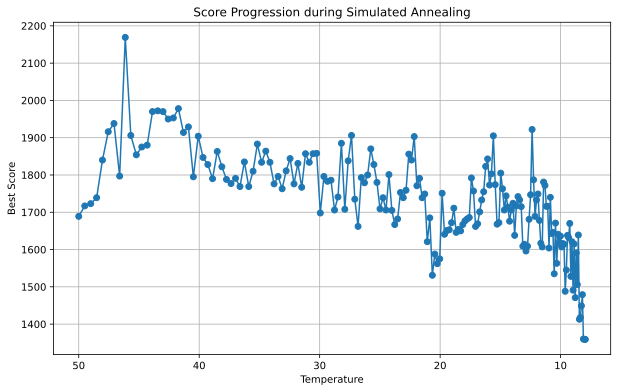

In [245]:
#sa 実行

c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1000)
c = pyzx.optimize.basic_optimization(c)
initial_graph = c.to_graph()
#pyzx.simplify.full_reduce(initial_graph, quiet=True) # 初期グラフを簡略化
pyzx.simplify.spider_simp(initial_graph)
pyzx.simplify.to_gh(initial_graph) #red node -> green
pyzx.simplify.id_simp(initial_graph)


print("初期グラフが生成されました。")
initial_score = score(initial_graph)

# 2. 焼きなまし法の設定と実行
print("\n--- 焼きなまし法を開始 ---")
sa = SimulatedAnnealer(
    initial_temp=50.0,      # 初期温度
    final_temp=0.1,         # 最終温度
    cooling_rate=0.99,      # 冷却率
    max_iterations=5        # 各温度での試行回数
)

best_graph, best_score_result, score_history = sa.solve(
    initial_state=initial_graph,
    evaluate_func=score,
    get_neighbor_func=get_neighbor_scores # ここで「最も良い近傍を選ぶ」関数を指定
)

# 3. 結果の表示
print("\n--- 結果 ---")
print(f"初期スコア: {initial_score}")
print(f"最終的な最良スコア: {best_score_result}")

print("\n初期グラフ:")
pyzx.draw(initial_graph, labels=True)

print("\n最適化後のグラフ:")
pyzx.draw(best_graph, labels=True)

# 4. スコア履歴のプロット
plt.figure(figsize=(10, 6))
plt.plot(score_history['temp'], score_history['score'], marker='o')
plt.xlabel("Temperature")
plt.ylabel("Best Score")
plt.title("Score Progression during Simulated Annealing")
plt.gca().invert_xaxis() # 温度が高い方からプロット
plt.grid(True)
plt.show()





In [ ]:
c = generate_H_S_CNOT_T_circuit(8, 500, p_t=0.08, seed=1000)
#c = pyzx.optimize.basic_optimization(c)
#g = c.to_graph()
#pyzx.simplify.clifford_simp(g)
#print("clifford score", score(g))
print(c)

clifford score 1477
